In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [52]:
# load correlation matrix input to EFA
corrmat = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/phenos730_resid_80pct_corrmat.csv",index_col="Unnamed: 0")

In [53]:
# do eigendecomposition and pull first 36 components
eig_vals, eig_vecs = np.linalg.eig(corrmat)

In [54]:
# confirm first 36 eigenvecs correspond to the greatest eigenvals (in order)
pd.DataFrame(data=eig_vals,index=range(0,730)).sort_values(0,ascending=False)[0:36].index.tolist()==list(range(0,36))

True

In [55]:
# extract corresponding eigenvectors to dataframe
eigenvecs = pd.DataFrame(data=eig_vecs.T[0:36],columns=corrmat.columns).T

In [56]:
# get field names and create dict
phenos_730 = pd.read_csv("/stanley/robinson/ccarey/factor_invariance/input_phenos/phenos730_fields.tsv",sep="\t")
phenodict = dict(zip(phenos_730.fieldID,phenos_730.name))
phenodict_rev = dict(zip(phenos_730.name,phenos_730.fieldID))

In [57]:
# load in EFA loadings for comparison
efaloadings = pd.read_table("/stanley/robinson/ccarey/factor_paper_revision/test_absfin_fin_loadings_fin_convcheck_orig_minres_36_withsmc_allgt0.REPEAT_DEC_2020.txt",header=None)
efaloadings.columns=["item_name","factor","loading"]

In [58]:
corrmat.index.tolist()

['102',
 '1031',
 '1050',
 '1060',
 '1070',
 '1080',
 '1100',
 '110001',
 '1110',
 '1120',
 '1130',
 '1140',
 '1150_1',
 '1150_2',
 '1160',
 '1170',
 '1180',
 '1190',
 '1200',
 '1210',
 '1220',
 '1249',
 '1259',
 '1269',
 '1279',
 '1289',
 '129',
 '1299',
 '130',
 '1309',
 '1319',
 '1329',
 '1339',
 '134',
 '1349',
 '135',
 '1359',
 '136',
 '1369',
 '137',
 '1379',
 '1389',
 '1408',
 '1418_1',
 '1418_2',
 '1418_3',
 '1418_4',
 '1418_6',
 '1428_1',
 '1428_3',
 '1438',
 '1448_1',
 '1448_2',
 '1448_3',
 '1458',
 '1468_1',
 '1468_2',
 '1468_3',
 '1468_4',
 '1478',
 '1488',
 '1498',
 '1508_1',
 '1508_2',
 '1508_3',
 '1518',
 '1528',
 '1538_1',
 '1538_2',
 '1548',
 '1558',
 '1568',
 '1578',
 '1588',
 '1598',
 '1608',
 '1628',
 '1677',
 '1687',
 '1697',
 '1707_1',
 '1707_2',
 '1717',
 '1727',
 '1737',
 '1747_1',
 '1747_2',
 '1747_3',
 '1747_4',
 '1747_5',
 '1757',
 '1777',
 '1787',
 '1807',
 '1835',
 '1873',
 '1883',
 '189',
 '1920',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1980',
 '199

In [59]:
# convert to "wide" format (1 column per item)
efaloadings_wide = pd.pivot_table(efaloadings,values="loading",index="factor",columns="item_name") 
efaloadings_wide.columns = [phenodict_rev[x] for x in efaloadings_wide.columns]
efaloadings_wide = efaloadings_wide[corrmat.index.tolist()]

In [60]:
# get the inverse of the input correlation matrix
corrmat_inv =pd.DataFrame(np.linalg.inv(corrmat.values), corrmat.columns, corrmat.index)

In [61]:
# generate factor scores to compare to PC eigenvecs
efa_tocompare = pd.DataFrame(np.matmul(corrmat_inv.values,efaloadings_wide.T.values),efaloadings_wide.columns,efaloadings_wide.index)
efa_tocompare.columns = [str(x)+"_efa" for x in efa_tocompare.columns]

In [62]:
# prep eigenvec dataframe for comparison to efa
pca_tocompare = eigenvecs.copy()
pca_tocompare.columns = [str(x+1)+"_pca" for x in pca_tocompare.columns]

In [63]:
# concatenate EFA and PCA "loading" dataframes
allloadings = pd.concat([pca_tocompare,efa_tocompare],axis=1)

In [64]:
# generate correlations between pca and efa loadings in every factor
corrcompare = pd.concat([pca_tocompare,efa_tocompare],axis=1).corr()
toplot = corrcompare.loc[[x for x in corrcompare.columns if "pca" in x],[x for x in corrcompare.columns if "efa" in x]]

In [65]:
# rename fieldIDs to names for ease of understanding
allloadings.index = [phenodict[x] for x in allloadings.index]

In [66]:
B = efa_tocompare.copy()
W = pca_tocompare.copy()
S = corrmat.copy()

In [67]:
cov_fa_pca = np.matmul(np.matmul(B.T,S),W)

/local/scratch/42452845.1.interactive/ipykernel_7115/1874837388.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  cov_fa_pca = np.matmul(np.matmul(B.T,S),W)


In [68]:
var_fac = np.diag(np.matmul(np.matmul(B.T,S),B))

/local/scratch/42452845.1.interactive/ipykernel_7115/2037239721.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  var_fac = np.diag(np.matmul(np.matmul(B.T,S),B))


In [69]:
var_pcs = np.diag(np.matmul(np.matmul(W.T,S),W))

/local/scratch/42452845.1.interactive/ipykernel_7115/1320091842.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  var_pcs = np.diag(np.matmul(np.matmul(W.T,S),W))


In [70]:
cor_overall = np.matmul(np.matmul(np.diag(1/np.sqrt(var_fac)),cov_fa_pca),np.diag(1/np.sqrt(var_pcs)))

In [71]:
cor_overall = np.matmul(np.matmul(np.diag(1/np.asarray([1]*36)),cov_fa_pca),np.diag(1/np.sqrt(var_pcs)))

In [72]:
toplot_htmp = cor_overall.copy()

In [73]:
toplot_htmp.columns = toplot_htmp.columns+1

In [74]:
toplot_htmp.index = toplot_htmp.index+1

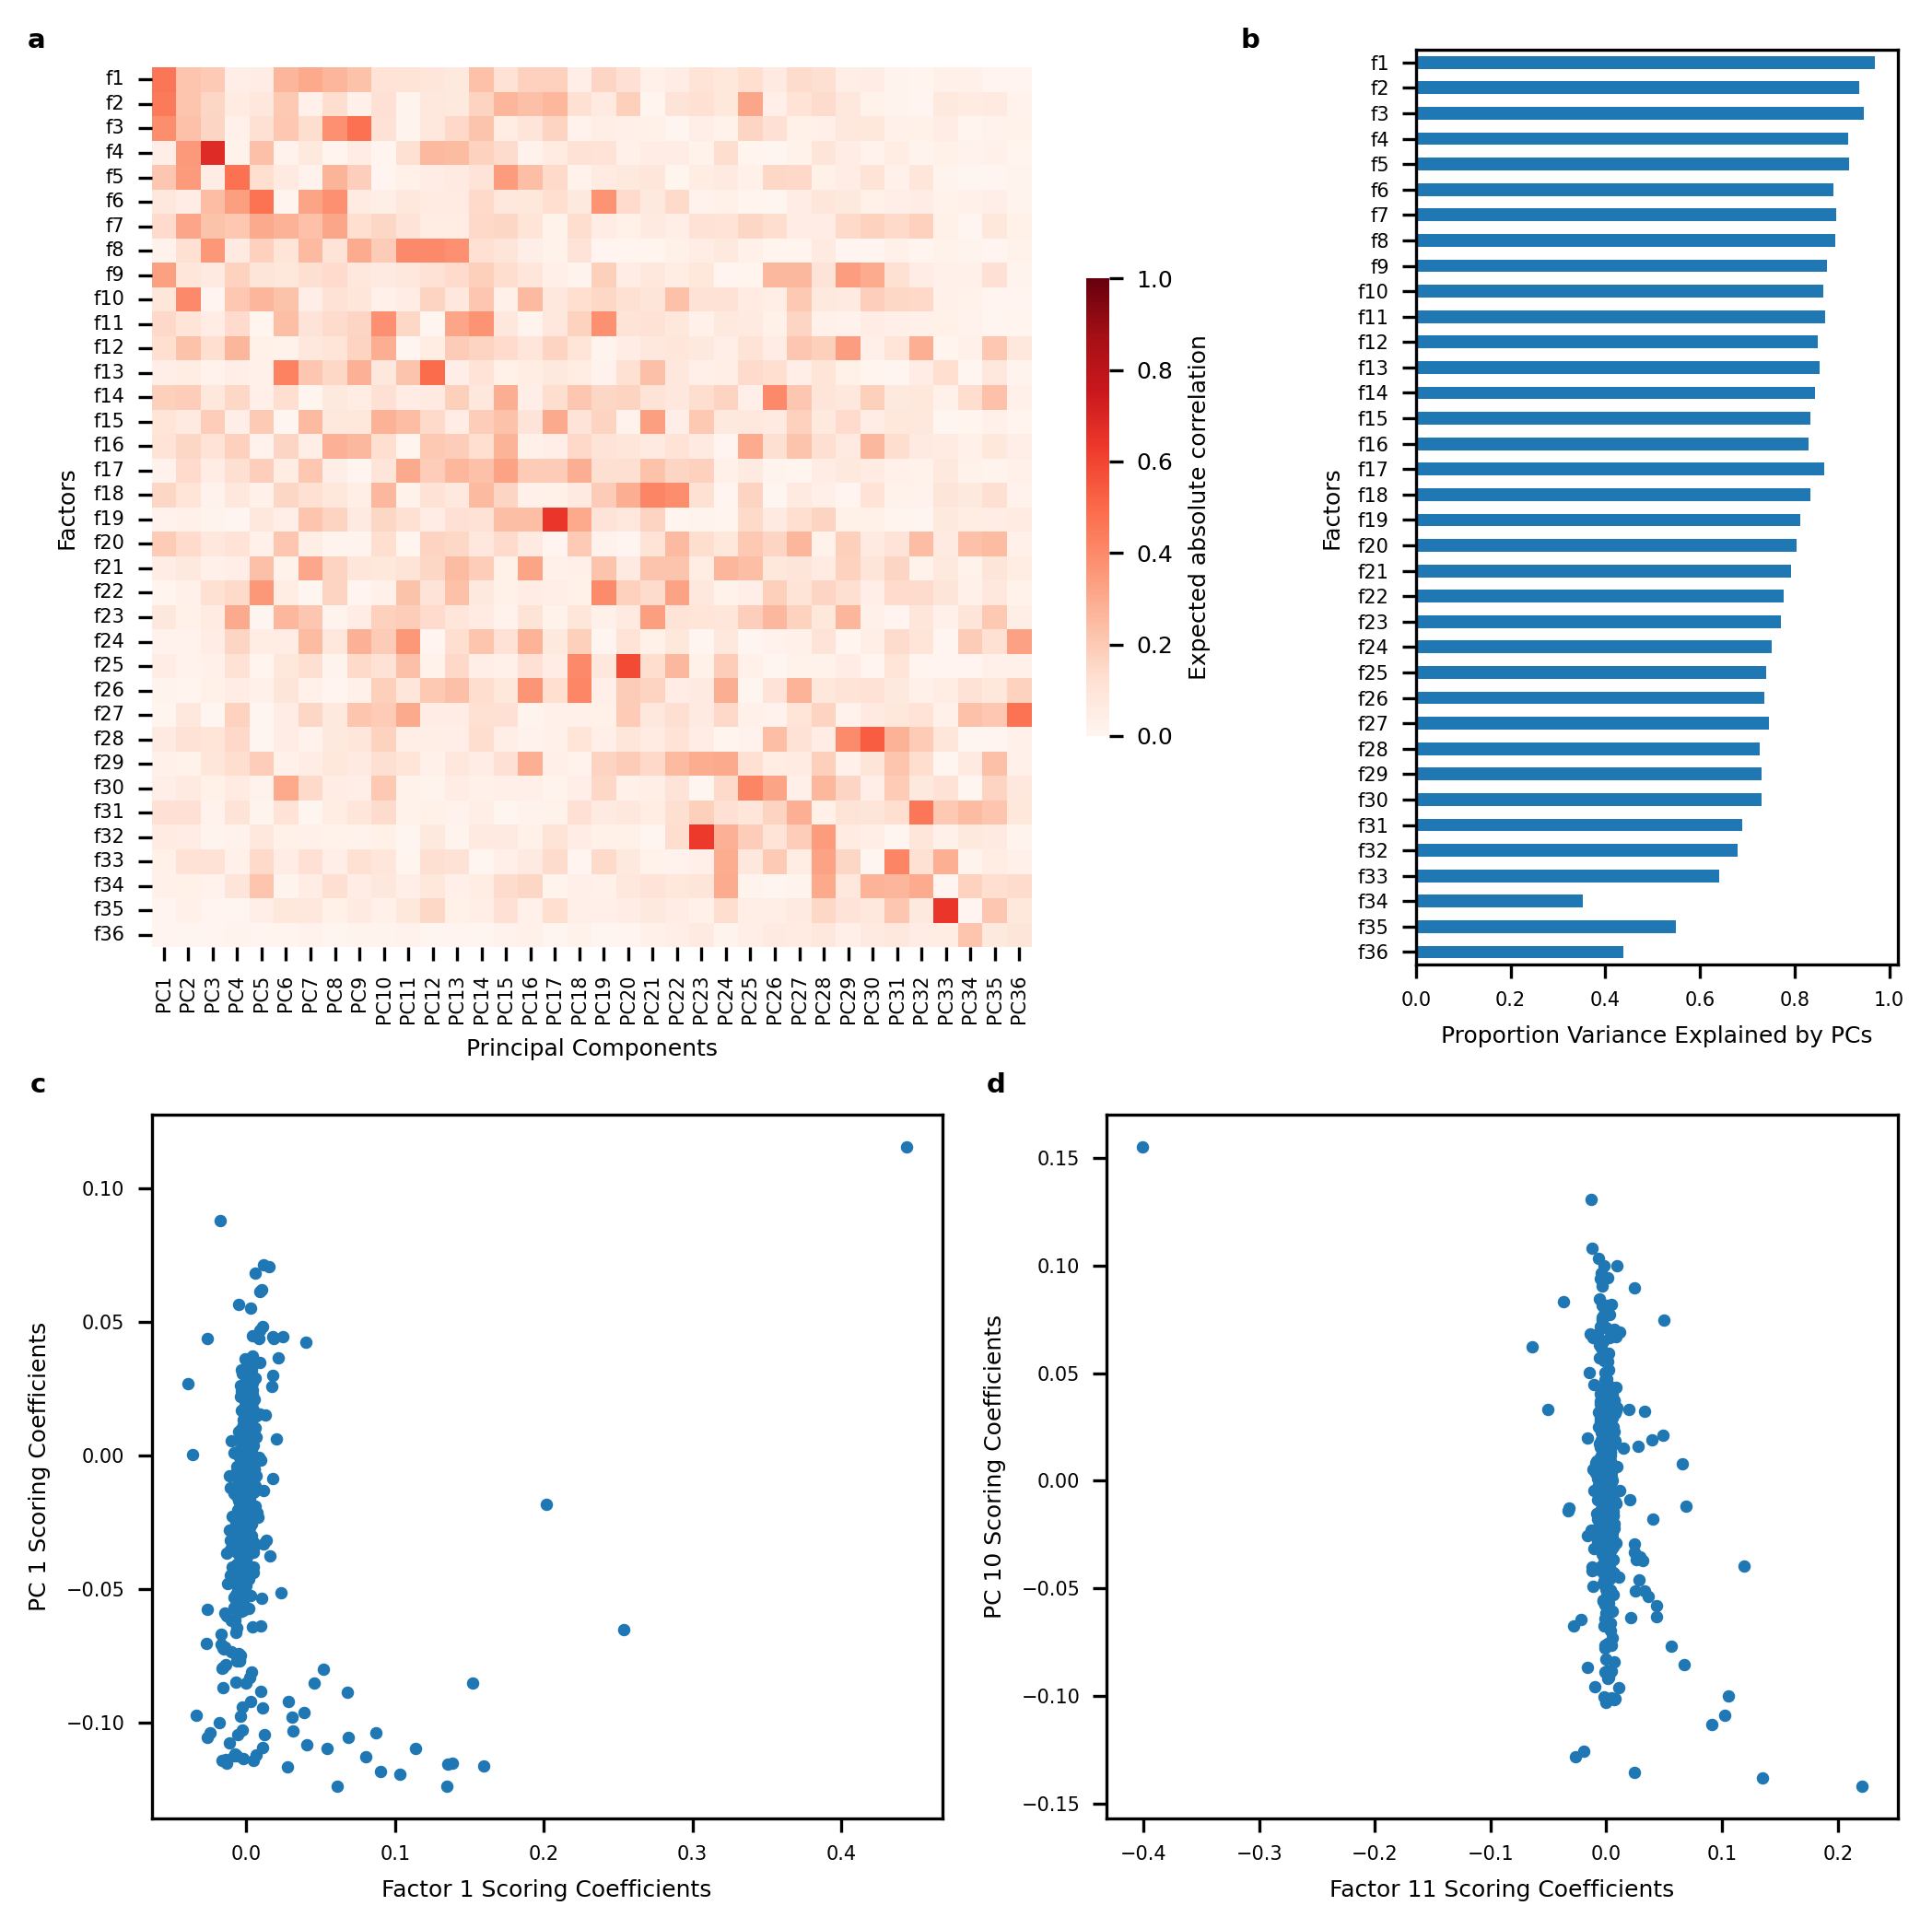

In [75]:
# plot heatmap
fig = plt.figure(figsize=(7.086,7), dpi=300)
gs = fig.add_gridspec(2,4,height_ratios=[1.3,1], width_ratios=[1,0.3,0.3,1])
ax1 = fig.add_subplot(gs[0, :-1])
hm = sns.heatmap(abs(toplot_htmp),square=True,vmax=1, vmin=0,cmap="Reds",cbar=True, cbar_kws={"shrink":0.5})
hm.collections[0].colorbar.set_label("Expected absolute correlation", fontsize=6)
ax1.collections[0].colorbar.ax.tick_params(labelsize=6)
plt.setp(ax1, yticks=np.arange(0.5,36.5,1), yticklabels=['f' + str(x) for x in range(1,37)])
plt.setp(ax1, xticks=np.arange(0.5,36.5,1), xticklabels=['PC' + str(x) for x in range(1,37)])
plt.yticks(rotation=0, fontsize=5)
plt.xticks(rotation=90, fontsize=5)
plt.gca().set_xlabel("Principal Components", fontsize=6)
plt.gca().set_ylabel("Factors", fontsize=6)
ax1.tick_params(axis='both', which='major', labelsize=5)

ax2 = fig.add_subplot(gs[0, 3])
(cor_overall**2).sum().plot.barh()
plt.gca().set_ylabel("Factors", fontsize=6)
plt.gca().set_xlabel("Proportion Variance Explained by PCs", fontsize=6)
plt.gca().set_yticklabels(['f' + str(x) for x in range(1,37)])
plt.gca().invert_yaxis()
ax2.tick_params(axis='both', which='major', labelsize=5)


ax3 = fig.add_subplot(gs[1, :-2])
plt.scatter(data=allloadings,x="1_efa",y="1_pca",s=5)
plt.gca().set_xlabel("Factor 1 Scoring Coefficients", fontsize=6)
plt.gca().set_ylabel("PC 1 Scoring Coefficients", fontsize=6)
ax3.tick_params(axis='both', which='major', labelsize=5)


ax4 = fig.add_subplot(gs[1, -2:])
plt.scatter(data=allloadings,x="11_efa",y="10_pca",s=5)
plt.gca().set_xlabel("Factor 11 Scoring Coefficients", fontsize=6)
plt.gca().set_ylabel("PC 10 Scoring Coefficients", fontsize=6)
ax4.tick_params(axis='both', which='major', labelsize=5)



fig.text(0.03, 0.99, "a",
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.65, 0.99, "b",
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.03, 0.45, "c",
      fontsize=7, fontweight='bold', va='top', ha='right')
fig.text(0.52, 0.45, "d",
      fontsize=7, fontweight='bold', va='top', ha='right')

fig.tight_layout()
# gs.tight_layout(fig, w_pad=.5, h_pad=1)
fig.savefig("/stanley/robinson/ccarey/factor_paper_revision/edfigs_CEC/EDFig3.eps") #,bbox_inches="tight")
